# ÖDEV 1: PCA yardımı ile Classification,

Bu ödevde "Credit Risk Prediction" veri setini kullanacağız. Amacımız, verinin boyut sayısını düşürerek olabildiğince yüksek accuracy değerini alabilmek. Aşağıda verinin okunma ve temizlenme kısmını hazırlayıp vereceğim. Devamında ise yapmanız gerekenler:

1. PCA kullanarak verinin boyutunu düşürmek
    * Önce explained varience ratio değerini inceleyerek veriyi kaç boyuta düşürebileceğini kontrol et.
    * Daha sonra farklı boyutlarda denemeler yaparak boyutu düşürülmüş verileri elde et.
2. Classification modellerini dene
    * Logistic Regression
    * Random Forest
    * ve eğer istersen herhangi bir modelle daha

İsteğe bağlı olarak, verinin boyutunu düşürmek için diğer yöntemleri de kullanıp en yüksek accuracy değerini almayı deneyebilirsin.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df: pd.DataFrame = pd.read_csv('./credit_risk_dataset.csv')

In [3]:
print(df.isnull().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [4]:
# Null değerleri sütun ortalaması ile dolduruyoruz
df["person_emp_length"].fillna(df["person_emp_length"].median(), inplace=True)
df["loan_int_rate"].fillna(df["loan_int_rate"].median(), inplace=True)

In [5]:
df.duplicated().sum()

165

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32416.0,27.747008,6.354100,20.00,23.00,26.00,30.00,144.00
person_income,32416.0,66091.640826,62015.580269,4000.00,38542.00,55000.00,79218.00,6000000.00
person_emp_length,32416.0,4.768880,4.090411,0.00,2.00,4.00,7.00,123.00
loan_amnt,32416.0,9593.845632,6322.730241,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,32416.0,11.014662,3.083050,5.42,8.49,10.99,13.11,23.22
loan_status,32416.0,0.218688,0.413363,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32416.0,0.170250,0.106812,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32416.0,5.811297,4.059030,2.00,3.00,4.00,8.00,30.00


In [8]:
# Outlier temizliği
df = df[df['person_age']<=100]
df = df[df['person_emp_length'] <= 60]
df = df[df['person_income']<=4e6]

In [9]:
# Kategorik verileri alıyoruz ve one hot encoding haline getiriyoruz
cat_cols = pd.DataFrame(df[df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [10]:
encoded_cat_cols = pd.get_dummies(cat_cols)
df.drop(df.select_dtypes(include=['object']).columns, axis=1,inplace=True)
df = pd.concat([df,encoded_cat_cols], axis=1)

In [11]:
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

In [12]:
# Verileri train ve test olarak ikiye ayırıyoruz

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(1, test_size=0.1)
train_idx, test_idx = next(split.split(X, y))
train_x = X[train_idx]
test_x = X[test_idx]

train_y = y[train_idx]
test_y = y[test_idx]

## Kolay gelsin!

#### Scaling Train test

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()

In [19]:
scaled_X_train = scaler.fit_transform(train_x)

In [20]:
scaled_X_test = scaler.transform(test_x)

#### PCA n_components=2

In [21]:
from sklearn.decomposition import PCA

In [42]:
model = PCA(n_components=2)

In [45]:
pc_results = model.fit_transform(scaled_X_train)

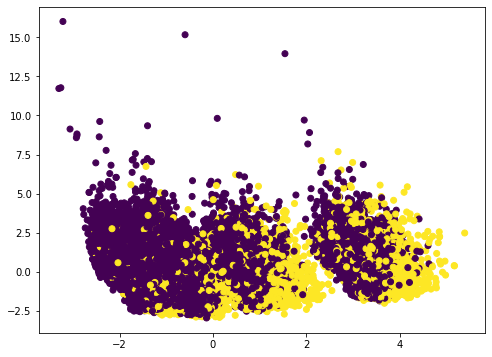

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(pc_results[:,0],pc_results[:,1],c=train_y);

#### Diffferent n_components

In [31]:
explained_variance =[]

for n in range(1,27):
    pca = PCA(n_components=n)
    pca.fit(scaled_X_train)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

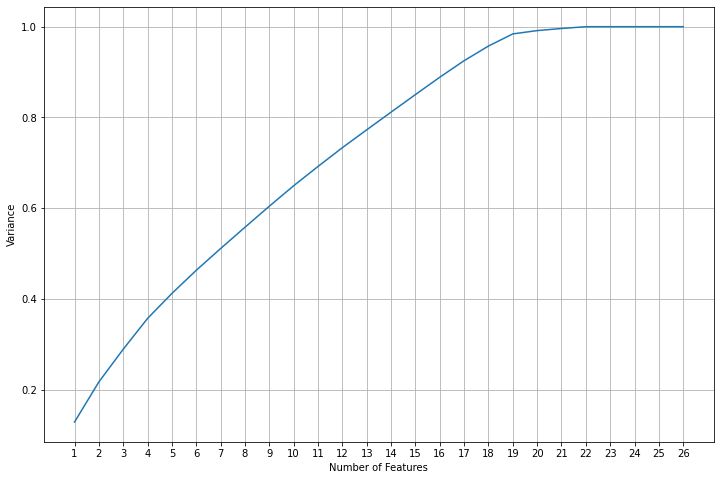

In [40]:
plt.figure(figsize=(12,8))
plt.grid()
plt.plot(range(1,27),explined_variance)
plt.xticks(ticks=range(1,27,1))
plt.xlabel('Number of Features')
plt.ylabel('Variance');

## Classification

In [111]:
pca_model = PCA(n_components=19)

In [112]:
X_train = pca_model.fit_transform(scaled_X_train)

In [113]:
X_train.shape

(29168, 19)

In [114]:
X_test = pca_model.transform(scaled_X_test)

In [115]:
X_test.shape

(3241, 19)

### Logistic Regression

In [76]:
from sklearn import linear_model
from sklearn import metrics

In [152]:
logistic_model = linear_model.LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5   
)

In [153]:
logistic_model.fit(X_train, train_y)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [154]:
log_preds = logistic_model.predict(X_test)

In [155]:
metrics.confusion_matrix(test_y, log_preds)

array([[2412,  120],
       [ 316,  393]], dtype=int64)

In [156]:
print(metrics.classification_report(test_y, log_preds))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      2532
           1       0.77      0.55      0.64       709

    accuracy                           0.87      3241
   macro avg       0.83      0.75      0.78      3241
weighted avg       0.86      0.87      0.86      3241



### Random Forest

In [157]:
from sklearn import ensemble

In [182]:
rf_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=8,
    min_samples_leaf=4,
    bootstrap=True,
    n_jobs=-1,
)

In [183]:
rf_model.fit(X_train, train_y)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=8,
                       n_jobs=-1)

In [184]:
rf_preds = rf_model.predict(X_test)

In [185]:
metrics.confusion_matrix(test_y, rf_preds)

array([[2482,   50],
       [ 252,  457]], dtype=int64)

In [186]:
print(metrics.classification_report(test_y, rf_preds))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2532
           1       0.90      0.64      0.75       709

    accuracy                           0.91      3241
   macro avg       0.90      0.81      0.85      3241
weighted avg       0.91      0.91      0.90      3241



### Random Forest has better scores than Logistic Regression